# NTF Value Prediction (CSCI-4850 Project)

## Setup

In [ ]:
import tensorflow.keras as keras
from tensorflow.keras import backend as K
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from random import randint
%matplotlib inline

In [118]:
image_dim = (128, 128)
image_count = 100

X = np.array([
    [
        [[0, 0, 0] for col in range(image_dim[1])]
        for row in range(image_dim[0])
    ] for _ in range(image_count)
])
Y1 = np.array([0.0 for _ in range(image_count)])
Y2 = np.array([0.0 for _ in range(image_count)])

display(X.shape)
display(Y1.shape)
display(Y2.shape)

(100, 128, 128, 3)

(100,)

(100,)

In [119]:
class ModelInfo:
    def __init__(self, weights, epochs=None):
        self.weights = weights
        self.epochs = epochs

    def load_model(self, model):
        model.set_weights(self.weights)
        
    def store_model(self, model, epochs=None):
        self.epochs = epochs if epochs is not None else self.epochs
        self.weights = model.get_weights()

class ModelHistory:
    def __init__(self):
        self.history = []
    
    def __iter__(self):
        return iter(self.history)
    
    def stash_model(self, model, epochs=None):
        self.history.append(ModelInfo(model.get_weights(), epochs))
        
def extend_history(old=None, new=None):
    if old is None:
        return new
    else:
        oh, nh = old.history, new.history
        for key in nh:
            if key in oh:
                oh[key].extend(nh[key])
            else:
                oh[key] = list(nh[key])
        return old

In [123]:
history = None
model_history = ModelHistory()

## Model Creation

Model: "NFT_Valuator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Layer (InputLayer)        [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
First_Convolution (Conv2D)      (None, 121, 121, 128 24704       Input_Layer[0][0]                
__________________________________________________________________________________________________
Second_Convolution (Conv2D)     (None, 116, 116, 64) 294976      First_Convolution[0][0]          
__________________________________________________________________________________________________
Third_Convolution (Conv2D)      (None, 113, 113, 32) 32800       Second_Convolution[0][0]         
_______________________________________________________________________________________

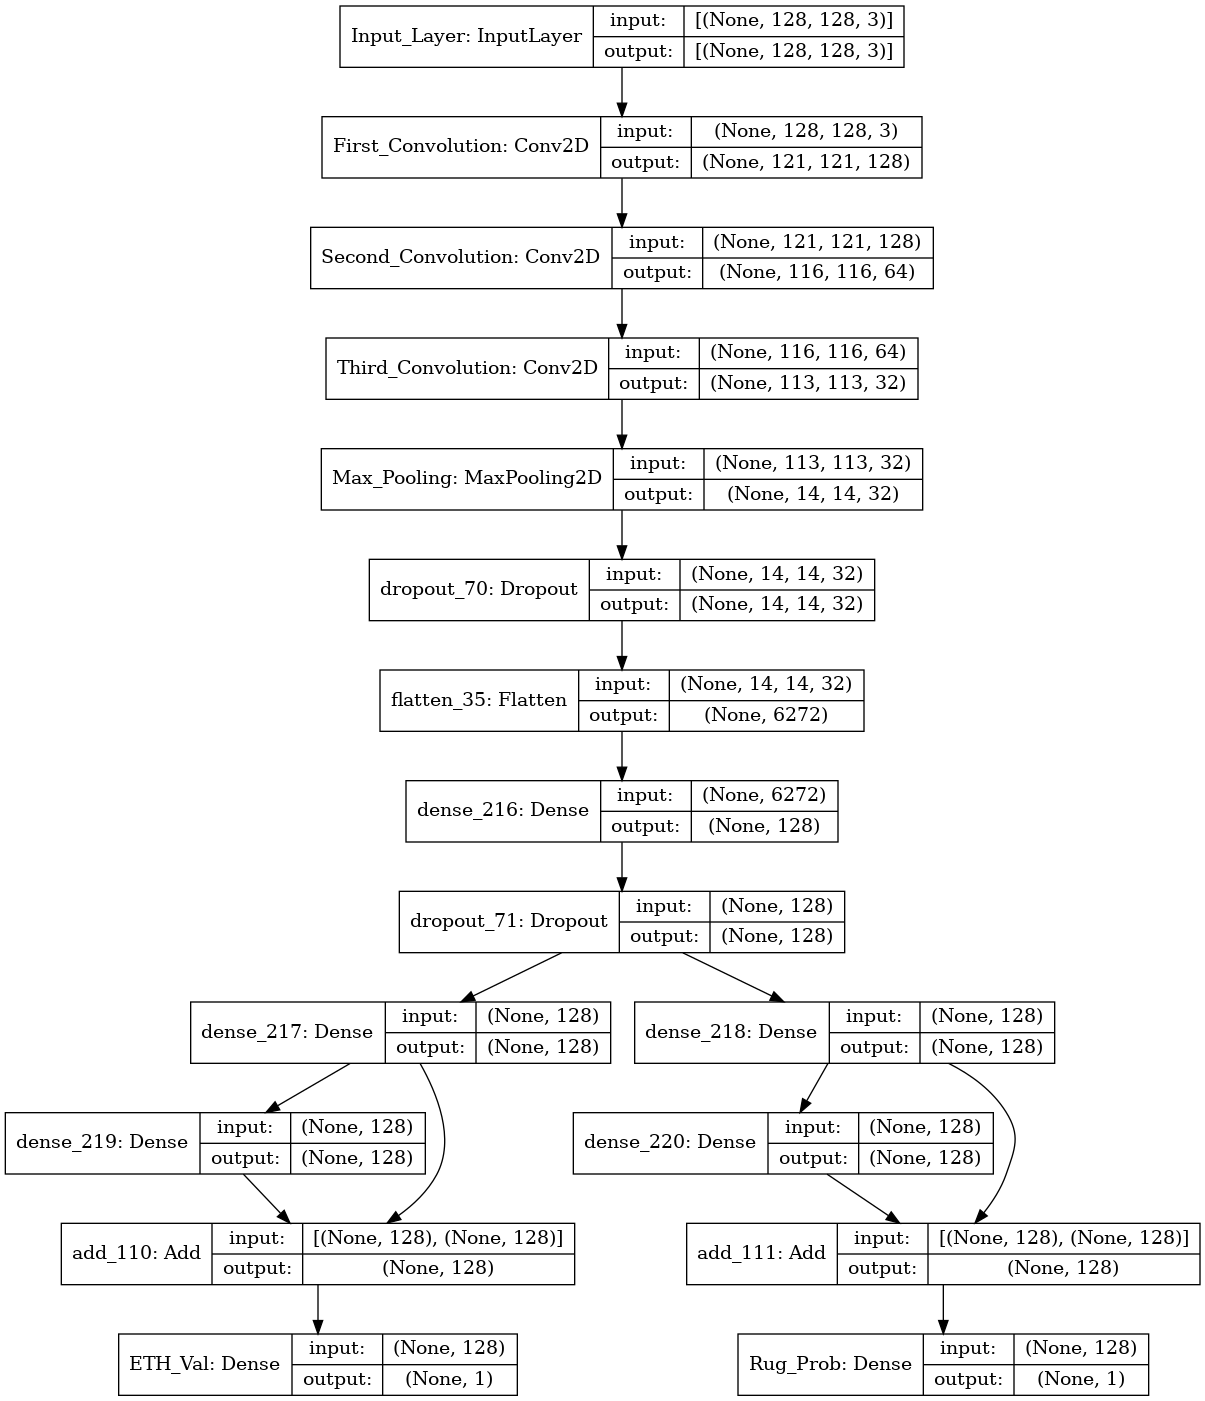

In [124]:
x = keras.layers.Input(X.shape[1:], name="Input_Layer")
y = x
y = keras.layers.Conv2D(128, kernel_size=(8,8), activation='relu', name="First_Convolution")(y)
y = keras.layers.Conv2D(64, kernel_size=(6,6), activation='relu', name="Second_Convolution")(y)
y = keras.layers.Conv2D(32, kernel_size=(4,4), activation='relu', name="Third_Convolution")(y)
y = keras.layers.MaxPooling2D(pool_size=(8,8), name="Max_Pooling")(y)
y = keras.layers.Dropout(0.05)(y)
y = keras.layers.Flatten()(y)
y = keras.layers.Dense(128, activation='relu')(y)
y = keras.layers.Dropout(0.125)(y)
z = keras.layers.Dense(128, activation='relu')(y)
y = keras.layers.Dense(128, activation='relu')(y)

stack = 1
for _ in range(stack):
    a = keras.layers.Dense(128, activation='relu')(z)
    b = keras.layers.Dense(128, activation='relu')(y)
    c = keras.layers.Add()([a, z])
    d = keras.layers.Add()([b, y])
    z, y = c, d
# y = keras.layers.LayerNormalization()(y)
# Output Logits (10)
a = keras.layers.Dense(1, activation='relu', name="ETH_Val")(z) # Ethereum value of the NFT
y = keras.layers.Dense(1, activation='sigmoid', name="Rug_Prob")(y) # Whether or not the NFT will "rug" (scam its buyers)
z = a
model = keras.Model(x,[z, y],name="NFT_Valuator")
generator = keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=0.05,
    height_shift_range=0.05,
    rotation_range=5,
    zoom_range=0.1,
    horizontal_flip=True
)
model.compile(
    loss={'ETH_Val': keras.losses.MeanSquaredError(), 'Rug_Prob': keras.losses.BinaryCrossentropy()},
    optimizer=keras.optimizers.Adam(),
    metrics={'ETH_Val': keras.metrics.MeanSquaredError(), 'Rug_Prob': keras.metrics.BinaryAccuracy()}
)
model.summary()
keras.utils.plot_model(model, show_shapes=True, expand_nested=True)

## Training

In [ ]:
batch_size = 15
epochs = 5
trials = 10

hr_w = 80
hr = '-' * hr_w

for t in range(trials):
    print(hr)
    print(f'TRIAL {t+1:,}'.center(hr_w))
    print(hr)
    history = extend_history(
        history, 
        model.fit(
            X, [Y1, Y2],
            batch_size=batch_size,
            epochs=epochs,
            verbose=1
        )
    )
    model_history.stash_model(model, epochs)

In [ ]:
plt.figure(1)
# summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['ETH_Val_mean_squared_error'])
plt.plot(history.history['Rug_Prob_binary_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ETH Value','Rug Probability'],loc='lower right')
# summarize history for loss
plt.subplot(212)
plt.plot(history.history['ETH_Val_loss'])
plt.plot(history.history['Rug_Prob_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ETH Value','Rug Probability'],loc='upper right')
plt.tight_layout()
plt.show()

In [ ]:
tests = 3
ep = 0
for i, stage in enumerate(model_history):
    stage.load_model(model)
    ep += stage.epochs
    print(hr)
    print(f'TEST {i+1:,} ({ep:,} EPOCHS)'.center(hr_w))
    print(hr)
    for test in range(tests):
        ri = randint(0, len(X)-1)
        print(f'\tIMG #{ri+1:,}')
        plt.imshow(X[ri])
        plt.show()
        print(f'\tREAL')
        print(f'\t\tPrice:{Y1[ri]:>25,.2f} Ξ')
        print(f'\t\tProbability:{Y2[ri]*100.0:>19,.2f} %')
        results = np.array(model.predict(X[ri:ri+1], verbose=0)).flatten()
        print(f'\tPRED')
        print(f'\t\tPrice:{results[0]:>25,.2f} Ξ')
        print(f'\t\tProbability:{results[1]*100.0:>19,.2f} %')
        print()